#  Chest X-Ray Images Model and Predictions
 ## Project Overview
 This dataset contains thousands of validated OCT and Chest X-Ray images  described and analyzed in "Identifying Medical Diagnoses and Treatable Diseases by Image-Based Deep Learning". The images are split into a training set and a testing set of independent patients. Images are labeled as (disease)-(randomized patient ID)-(image number by this patient) and split into 4 directories: CNV, DME, DRUSEN, and NORMAL.

## Data Understanding
The dataset has been split into two main parts: a training set and a testing set. These sets consist of images from different patients, and they are used to train and evaluate deep learning algorithms for medical diagnosis.

Each image is labeled with information indicating the type of disease, a randomized patient ID, and a unique image number for that patient. This labeling system helps in organizing and identifying specific images within the dataset.

## Problem Statement
The objective of this project is to develop a deep learning model capable of classifying chest X-ray images of pediatric patients to determine whether or not they have pneumonia.

Pneumonia is an infection that inflames the air sacs in one or both lungs. The air sacs may fill with fluid or pus, causing cough with phlegm or pus, fever, chills, and difficulty breathing.Chest X-ray, may help confirm the diagnosis.

In [139]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import  ImageDataGenerator
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import cv2

## Dataset Description
The dataset is organized into three folders, the train,test and validation which contain subfolders for each image category the Pneumonia and Normal.
The X-ray image category is  Pneumonia and Normal.

## Load the  Dataset.

In [161]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150

def get_data(data_dir):
    images = []
    classes = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                images.append(resized_arr)
                classes.append(class_num)
            except Exception as e:
                print(f"Error processing image: {os.path.join(path, img)}")
                print(e)
    return np.array(images), np.array(classes)
# Load data
train, train_labels = get_data('chest_xray/train')
test, test_labels = get_data('chest_xray/test')
val, val_labels = get_data('chest_xray/val')

In [122]:
train_labels

array([0, 0, 0, ..., 1, 1, 1])

## Data Visualization.

Checking out the dataset of two data points from data set.

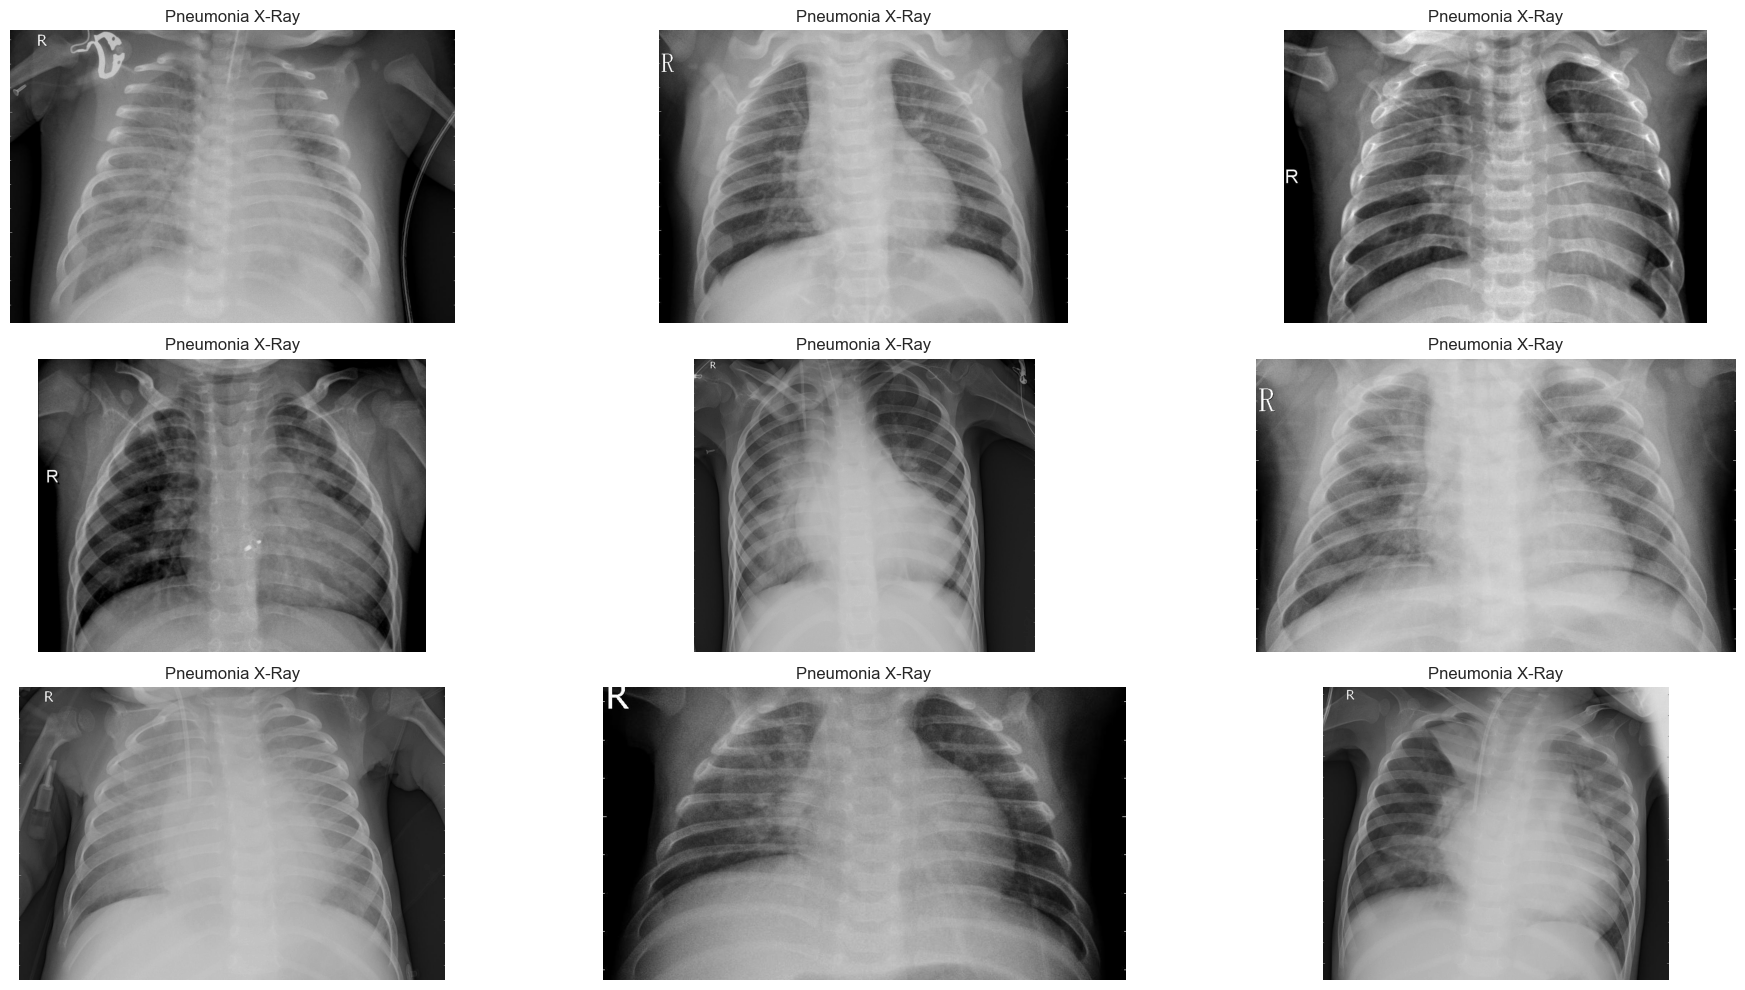

In [111]:
pneumonia = os.listdir("chest_xray/train/PNEUMONIA")
pneumonia_dir = "chest_xray/train/PNEUMONIA"

plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(pneumonia_dir, pneumonia[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title("Pneumonia X-Ray")
plt.tight_layout()

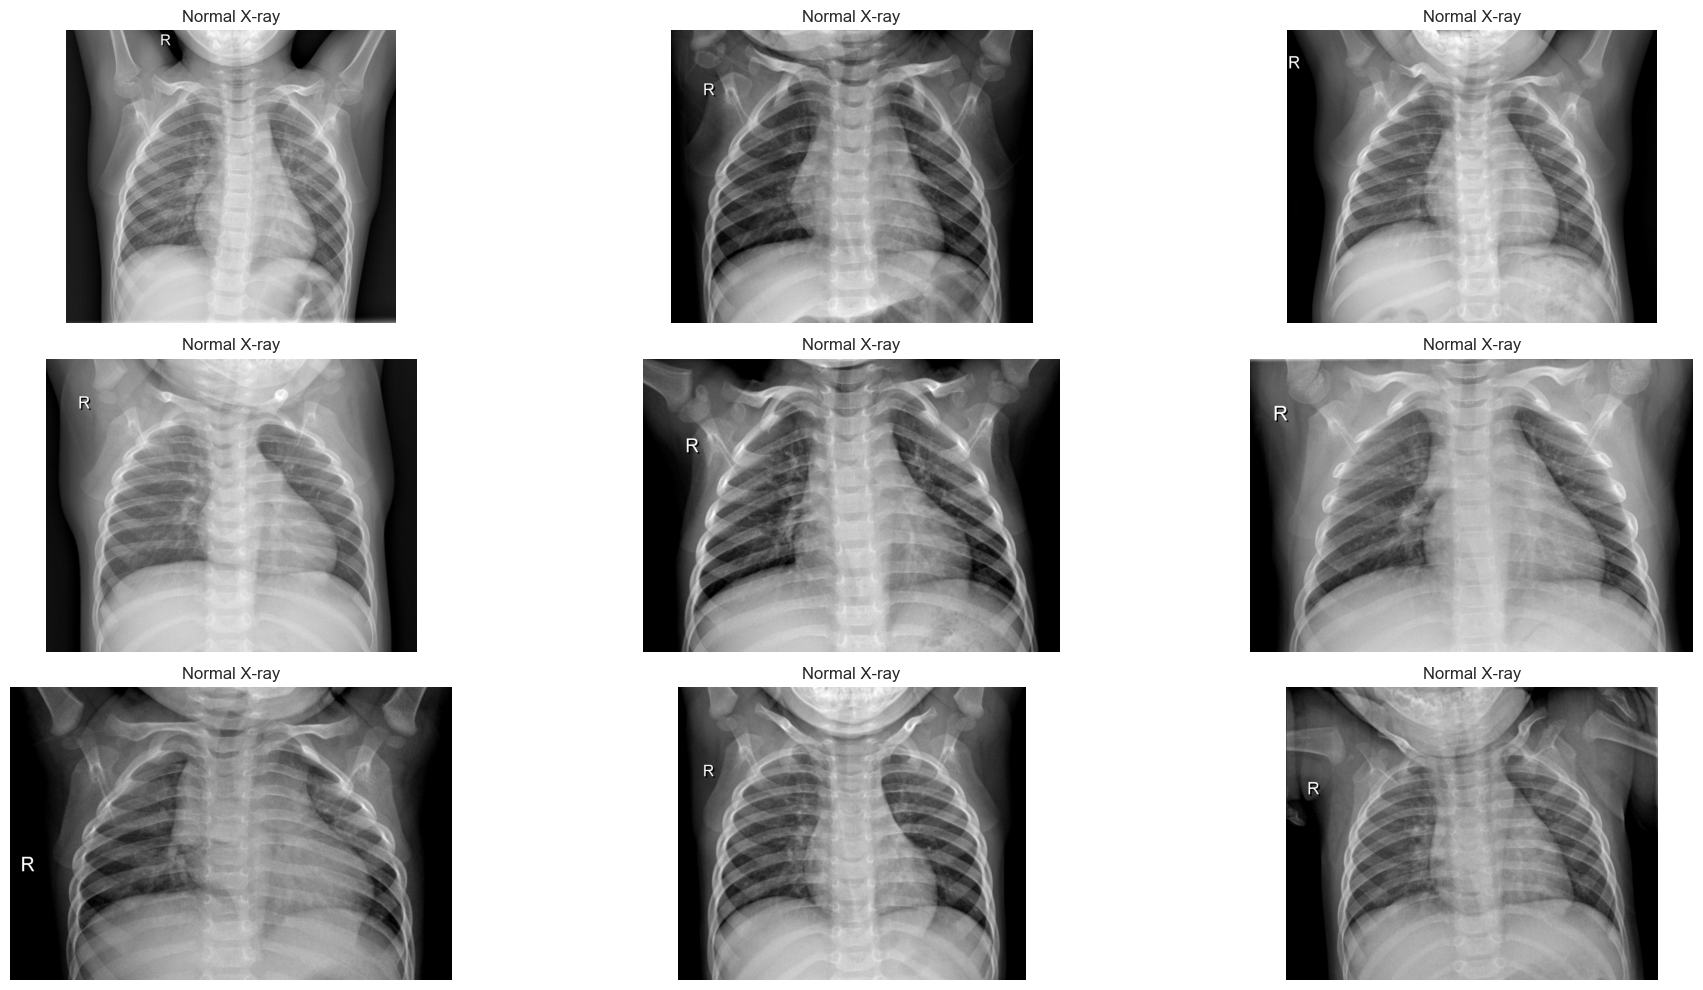

In [112]:
normal = os.listdir("chest_xray/train/NORMAL")
normal_dir = "chest_xray/train/NORMAL"

plt.figure(figsize=(20,10))

for i in range(9):
    plt.subplot(3,3, i +1)
    img = plt.imread(os.path.join(normal_dir, normal[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title('Normal X-ray')

plt.tight_layout()

Images of both the classes

Text(0.5, 1.0, 'NORMAL')

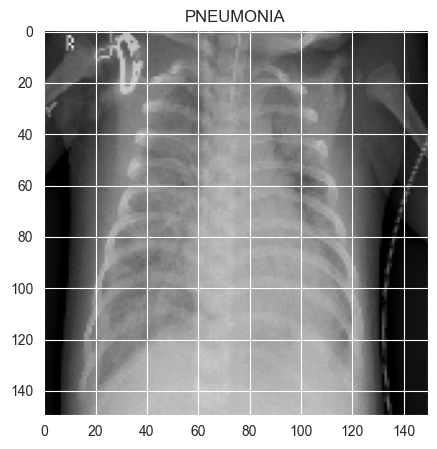

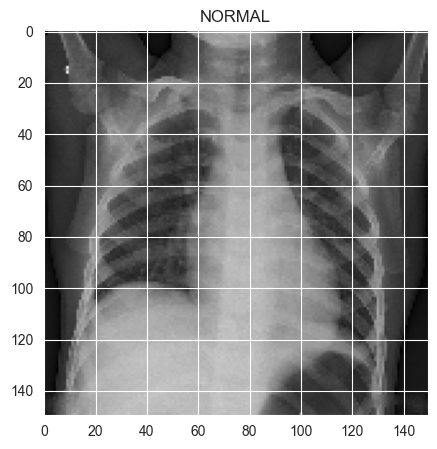

In [159]:
plt.figure(figsize=(5,5))
plt.imshow(train[0], cmap='gray')
plt.title(labels[train_labels[0]])

plt.figure(figsize=(5,5))
plt.imshow(train[-1], cmap='gray')
plt.title(labels[train_labels[-1]])

## Data Preprocessing

Normalization: Normalize the pixel values to be in the range of [0, 1]. This helps the model converge faster.

In [164]:
# Normalize pixel values
train_images = train / 255.0
test_images = test / 255.0
val_images = val / 255.0

Reshape Data: Ensure that the data is in the correct shape for model input. For CNNs, this typically means adding a channel dimension (for grayscale images) or making sure the channels are in the correct order (for RGB images).

In [165]:
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

In [167]:
# Reshape for CNN (add channel dimension)
train_images = train_images.reshape(-1, img_size, img_size, 1)
test_images = test_images.reshape(-1, img_size, img_size, 1)
val_images = val_images.reshape(-1, img_size, img_size, 1)

## Data Augmentation
Data augmentation is a powerful technique to artificially increase the diversity of your training set. This can help prevent overfitting and improve the model's generalization.

In [66]:
# Initialize the ImageDataGenerator for augmentation
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fit the generator on your training data
datagen.fit(train_images)

# Create a generator to generate augmented data
augmented_data_generator = datagen.flow(train_images, train[1], batch_size=32)

## Modeling

In [67]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

## Compile Model

Compiling the model with an optimizer, loss function, and metrics.

In [68]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

## Training Model

Using the augmented data generator to train the model.

In [69]:
history = model.fit(augmented_data_generator, epochs=10, validation_data=(val_images, val[1]))

Epoch 1/10
163/163 [==============================] - 111s 672ms/step - loss: 0.5329 - accuracy: 0.7454 - val_loss: 0.6269 - val_accuracy: 0.6250
Epoch 2/10
163/163 [==============================] - 131s 805ms/step - loss: 0.3675 - accuracy: 0.8267 - val_loss: 0.6394 - val_accuracy: 0.7500
Epoch 3/10
163/163 [==============================] - 166s 1s/step - loss: 0.3216 - accuracy: 0.8501 - val_loss: 0.7140 - val_accuracy: 0.7500
Epoch 4/10
163/163 [==============================] - 178s 1s/step - loss: 0.2832 - accuracy: 0.8756 - val_loss: 0.5006 - val_accuracy: 0.8125
Epoch 5/10
163/163 [==============================] - 153s 940ms/step - loss: 0.2744 - accuracy: 0.8798 - val_loss: 0.5221 - val_accuracy: 0.7500
Epoch 6/10
163/163 [==============================] - 145s 889ms/step - loss: 0.2527 - accuracy: 0.8888 - val_loss: 0.6429 - val_accuracy: 0.7500
Epoch 7/10
163/163 [==============================] - 147s 901ms/step - loss: 0.2337 - accuracy: 0.9028 - val_loss: 0.5812 - val_a

## Evaluating Model

In [71]:
test_loss, test_accuracy = model.evaluate(test_images, test[1])
print(f"Test Accuracy: {test_accuracy}")

20/20 [==============================] - 4s 193ms/step - loss: 0.2786 - accuracy: 0.8846
Test Accuracy: 0.8846153616905212


## Visualizing Accuracy and Loss

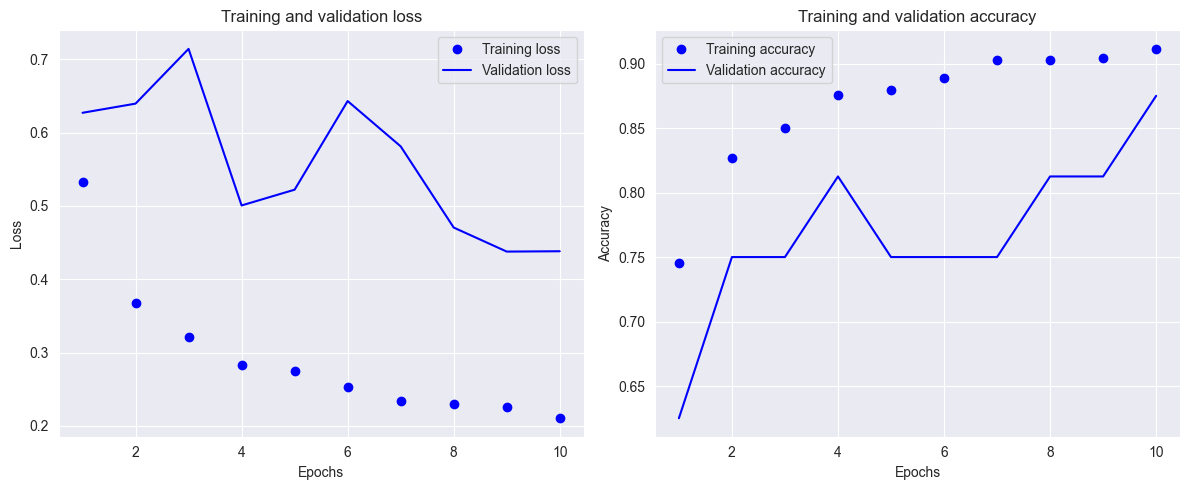

In [70]:
# Get the training history
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)

# training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()


## Predictions

In [169]:

predictions = model.predict(test_images)
predictions = predictions.reshape(1,-1)[0]
predictions[:15]


1/1 [==============================] - 0s 149ms/step


array([0.14408882], dtype=float32)